In [19]:
import pandas as pd
import numpy as np
import math as math
import statistics
import time
import datetime
from scipy.stats import pearsonr
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('max_colwidth', 1000)  
pd.set_option('display.width', 150)
NBATeams =['ATL','BKN','BOS','CHA','CHI','CLE','DAL','DEN','DET','GSW','HOU','IND','LAC','LAL','MEM',
           'MIA','MIL','MIN','NOP','NYK','OKC','ORL','PHI','PHX','POR','SAC','SAS','TOR','UTA','WAS']

# Glossary.csv SOURCED FROM:
https://www.nba.com/stats/help/glossary

In [7]:
glossaryDF = pd.read_csv('/Users/olutosinfashusi/jupyter/csv/Glossary.csv')
glossaryDict = {}
for i in range(len(glossaryDF)):
    stringInRow = glossaryDF.iloc[i].values[0]
    if stringInRow == 'Name':
        feature = glossaryDF.iloc[i-1].values[0]
        feature = feature.upper()
        glossaryDict[feature] = {}
        glossaryDict[feature]['Name'] = {}
        glossaryDict[feature]['Name'] = glossaryDF.iloc[i+1].values[0]
        glossaryDict[feature]['Definition'] = {}
        glossaryDict[feature]['Definition'] = glossaryDF.iloc[i+3].values[0]
        glossaryDict[feature]['Type'] = {}
        glossaryDict[feature]['Type'] = glossaryDF.iloc[i+5].values[0]
        glossaryDict[feature]['Contexts'] = {}
        
#FEATURES NOT IN https://www.nba.com/stats/help/glossary
glossaryDict['H/A'] = {}
glossaryDict['H/A']['Name'] = 'Home or Away'
glossaryDict['H/A']['Definition'] = '0:HOME 1:AWAY'

glossaryDict['PTSA'] = {}
glossaryDict['PTSA']['Name'] = 'Points Allowed'
glossaryDict['PTSA']['Definition'] = 'The number of points allowed'

glossaryDict['PTSDELTA'] = {}
glossaryDict['PTSDELTA']['Name'] = 'Points Scored - Points Allowed'
glossaryDict['PTSDELTA']['Definition'] = 'Points Scored - Points Allowed'

glossaryDict['DAYSOFF'] = {}
glossaryDict['DAYSOFF']['Name'] = 'Number of days since last game'
glossaryDict['DAYSOFF']['Definition'] = 'Number of days since last game'

glossaryDict['W%'] = {}
glossaryDict['W%']['Name'] = 'The percentage of games played that a player or team has won'
glossaryDict['W%']['Definition'] = 'The percentage of games played that a player or team has won'

glossaryDict['L%'] = {}
glossaryDict['L%']['Name'] = 'The percentage of games played that a player or team has lost'
glossaryDict['L%']['Definition'] = 'The percentage of games played that a player or team has lost'

In [8]:
def convertDateColumn(df):
    locationToInsert = df.columns.get_loc('DATE')+1
    dates = pd.to_datetime(df['DATE'],format="%m/%d/%y").dt.date
    df = df.drop(columns='DATE')
    df.insert(locationToInsert,'DATE',dates)
    df = df.sort_values(by=['DATE','GAMEID']).reset_index(drop=True)
    return df
def featureEngineering(boxScoreType,df):
    if boxScoreType == 'TRADITIONAL':
        featuresToAddDict = {'OPPT':[],'PTSA':[],'2FGA':[],'2FGM':[],'2FG%':[],
                             'RESULT':[],'PTSDELTA':[],'H/A':[]}
        for i in range(len(df)):
            featuresToAddDict['OPPT'].append(df.iloc[i]['MATCH'][-3:])
            if i % 2 == 0: featuresToAddDict['PTSA'].append(df.iloc[i+1]['PTS'])
            else: featuresToAddDict['PTSA'].append(df.iloc[i-1]['PTS'])
            if df['W/L'][i] == 'L': featuresToAddDict['RESULT'].append(0)
            else: featuresToAddDict['RESULT'].append(1)
            featuresToAddDict['H/A'].append(df['MATCH'][i].count('vs'))
        df.insert(df.columns.get_loc('TEAM')+1,'OPPT',featuresToAddDict['OPPT'])
        df.insert(df.columns.get_loc('PTS')+1,'PTSA',featuresToAddDict['PTSA'])
        df.insert(df.columns.get_loc('FG%')+1,'2FGM',df['FGM'] - df['3PM'])
        df.insert(df.columns.get_loc('FG%')+1,'2FGA',df['FGA'] - df['3PA']) 
        df.insert(df.columns.get_loc('FG%')+1,'2FG%',df['2FGM']/df['2FGA'])
        df.insert(df.columns.get_loc('W/L')+1,'RESULT',featuresToAddDict['RESULT'])
        df = df.drop(columns=['W/L'])
        df.insert(df.columns.get_loc('PTSA')+1,'PTSDELTA',df['PTS']-df['PTSA'])
        df.insert(df.columns.get_loc('DATE')+1,'H/A',featuresToAddDict['H/A'])
        return df
    else:
        featuresToAddDict = {"OPPT":[],"RESULT":[],"H/A":[]}
        for i in range(len(df)):
            featuresToAddDict["OPPT"].append(df.iloc[i]['MATCH'][-3:])
            if df['W/L'][i] == 'L': featuresToAddDict["RESULT"].append(0)
            else: featuresToAddDict["RESULT"].append(1)
            featuresToAddDict["H/A"].append(df['MATCH'][i].count('vs'))
        df.insert(df.columns.get_loc('TEAM')+1,'OPPT',featuresToAddDict["OPPT"])
        df.insert(df.columns.get_loc('W/L')+1,'RESULT',featuresToAddDict["RESULT"])
        df = df.drop(columns=['W/L'])
        df.insert(df.columns.get_loc('DATE')+1,'H/A',featuresToAddDict["H/A"])
        return df
def addDaysOff(teamsDict):
    for team in list(teamsDict.keys()):
        daysOff = []
        daysOff.append(np.nan)
        for i in range(1,len(teamsDict[team]['DATE'])):
            date = teamsDict[team]['DATE'][i]
            prevDate = teamsDict[team]['DATE'][i-1] + datetime.timedelta(1)
            daysOff.append((date - prevDate).days)
        teamsDict[team]['DAYSOFF'] = daysOff
def addAdditionalFeatures(df,teamsDict):
    teams = []
    for team in list(teamsDict.keys()):
        teamDF = df[df['TEAM'] == team]
        startingIndex = len(list(df.columns))
        additionalFeatures = list(teamsDict[team].keys())[startingIndex:]
        for feature in additionalFeatures:
            teamDF = pd.concat([teamDF,
                                pd.DataFrame(teamsDict[team][feature],columns=[feature],index=teamDF.index.values)],axis=1)
        teams.append(teamDF)
    return pd.concat(teams)

def getTeamData(boxScoreType,df):
    teamsDict = {}
    features = df.columns.values
    
    if boxScoreType == 'TRADITIONAL': additionalFeatures = ['Ws','Ls','GP','W%','L%','AVGPTS','AVGPTSA']
  
    else: additionalFeatures = ['GP']
    for team in np.unique(df['TEAM']):
        teamsDict[team] = {}
    for team in np.unique(df['TEAM']):
        for feature in features:
            teamsDict[team][feature] = []
        for feature in additionalFeatures:
            teamsDict[team][feature] = []
    for i in range(len(df)):
        for feature in features:
            team = df.iloc[i]['TEAM']
            teamsDict[team][feature].append(df.iloc[i][feature])
        for feature in additionalFeatures:
            if feature == 'Ws': teamsDict[team][feature].append(teamsDict[team]['RESULT'].count(1))
            if feature == 'Ls': teamsDict[team][feature].append(teamsDict[team]['RESULT'].count(0))
            if feature == 'GP': teamsDict[team][feature].append(len(teamsDict[team]['RESULT']))
            if feature == 'W%': teamsDict[team][feature].append(teamsDict[team]['Ws'][-1]/teamsDict[team]['GP'][-1])
            if feature == 'L%': teamsDict[team][feature].append(teamsDict[team]['Ls'][-1]/teamsDict[team]['GP'][-1])
            if feature == 'AVGPTS': teamsDict[team][feature].append(np.mean(teamsDict[team]['PTS']))
            if feature == 'AVGPTSA': teamsDict[team][feature].append(np.mean(teamsDict[team]['PTSA']))
    return teamsDict

def addMovingAverageLx(featureStringsDict,teamDict,x):
    for team in list(teamsDict.keys()):
        for feature in featureStringsDict.keys():
            ma = []
            for _ in range(x): ma.append(np.nan)
            for maRange in range(0,len(teamsDict[team][feature])-x):
                ma.append(np.mean(teamsDict[team][feature][maRange:(x+maRange)]))
            teamsDict[team][featureStringsDict[feature].replace('x',str(x))] = ma
                
def addPercentMovingAverageLx(featureStringsDict,teamsDict,x):
    for team in list(teamsDict.keys()):
        for features in featureStringsDict.keys():
            ma = []
            for _ in range(x): ma.append(np.nan)
            for maRange in range(0,len(teamsDict[team][features[0]])-x):
                num = np.sum(teamsDict[team][features[0]][maRange:(x+maRange)])
                dem = np.sum(teamsDict[team][features[1]][maRange:(x+maRange)])
                ma.append(num/dem)
            teamsDict[team][featureStringsDict[features].replace('x',str(x))] = ma

# Traditional.csv

In [9]:
traditionalDF = pd.read_csv('/Users/olutosinfashusi/jupyter/csv/fromNBADOTCOM/2023-24/byGame/Traditional.csv')
traditionalDF = convertDateColumn(traditionalDF)
traditionalDF = featureEngineering('TRADITIONAL',traditionalDF)
teamsDict = getTeamData('TRADITIONAL',traditionalDF)

In [10]:
features = ['PTS','PTSA','PTSDELTA','FGM','FGA','2FGA','2FGM','3PM','3PA','FTM','FTA','OREB',
            'DREB','REB','AST','STL','BLK','TOV','PF']
featureStringsDict = {}
for feature in features: featureStringsDict[feature] = feature+'LxMA'
addMovingAverageLx(featureStringsDict,teamsDict,5)
addMovingAverageLx(featureStringsDict,teamsDict,4)
addMovingAverageLx(featureStringsDict,teamsDict,3)
addMovingAverageLx(featureStringsDict,teamsDict,2)
addMovingAverageLx(featureStringsDict,teamsDict,1)
features = [('FGM','FGA'),('2FGM','2FGA'),('3PM','3PA'),('FTM','FTA'),('Ws','GP')]
featureStringsDict = {}
for feature in features:
    if feature == ('FGM','FGA'): featureStringsDict[feature] = 'FG%LxMA'
    if feature == ('2FGM','2FGA'): featureStringsDict[feature] = '2FG%LxMA'
    if feature == ('3PM','3PA'): featureStringsDict[feature] = '3P%LxMA'
    if feature == ('FTM','FTA'): featureStringsDict[feature] = 'FT%LxMA'
    if feature == ('Ws','GP'): featureStringsDict[feature] = 'W%LxMA'
addPercentMovingAverageLx(featureStringsDict,teamsDict,5)
addPercentMovingAverageLx(featureStringsDict,teamsDict,4)
addPercentMovingAverageLx(featureStringsDict,teamsDict,3)
addPercentMovingAverageLx(featureStringsDict,teamsDict,2)
addPercentMovingAverageLx(featureStringsDict,teamsDict,1)
addDaysOff(teamsDict)
traditionalDF = addAdditionalFeatures(traditionalDF,teamsDict)
traditionalDF = traditionalDF.sort_values(by=['DATE','GAMEID','H/A']).reset_index(drop=True)

<ipython-input-8-cc31cfbcd612>:107: RuntimeWarning: invalid value encountered in scalar divide
  ma.append(num/dem)


In [11]:
print('In rare occasion on 4/9/24 Celtics attempted 0 free throws vs Bucks')
print('Causing a warning while calculating Celtics FT%L1MA')
print('Excluded BOS FT%L1MA feature from train')
traditionalDF[traditionalDF['FTA'] == 0]

In rare occasion on 4/9/24 Celtics attempted 0 free throws vs Bucks
Causing a warning while calculating Celtics FT%L1MA
Excluded BOS FT%L1MA feature from train


,TEAM,OPPT,TEAMID,MATCH,GAMEID,RESULT,DATE,H/A,SPREAD,O/U,MIN,PTS,PTSA,PTSDELTA,FGM,FGA,FG%,2FG%,2FGA,2FGM,3PM,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,PF,+/-,Ws,Ls,GP,W%,L%,AVGPTS,AVGPTSA,PTSL5MA,PTSAL5MA,PTSDELTAL5MA,FGML5MA,FGAL5MA,2FGAL5MA,2FGML5MA,3PML5MA,3PAL5MA,FTML5MA,FTAL5MA,OREBL5MA,DREBL5MA,REBL5MA,ASTL5MA,STLL5MA,BLKL5MA,TOVL5MA,PFL5MA,PTSL4MA,PTSAL4MA,PTSDELTAL4MA,FGML4MA,FGAL4MA,2FGAL4MA,2FGML4MA,3PML4MA,3PAL4MA,FTML4MA,FTAL4MA,OREBL4MA,DREBL4MA,REBL4MA,ASTL4MA,STLL4MA,BLKL4MA,TOVL4MA,PFL4MA,PTSL3MA,PTSAL3MA,PTSDELTAL3MA,FGML3MA,FGAL3MA,2FGAL3MA,2FGML3MA,3PML3MA,3PAL3MA,FTML3MA,FTAL3MA,OREBL3MA,DREBL3MA,REBL3MA,ASTL3MA,STLL3MA,BLKL3MA,TOVL3MA,PFL3MA,PTSL2MA,PTSAL2MA,PTSDELTAL2MA,FGML2MA,FGAL2MA,2FGAL2MA,2FGML2MA,3PML2MA,3PAL2MA,FTML2MA,FTAL2MA,OREBL2MA,DREBL2MA,REBL2MA,ASTL2MA,STLL2MA,BLKL2MA,TOVL2MA,PFL2MA,PTSL1MA,PTSAL1MA,PTSDELTAL1MA,FGML1MA,FGAL1MA,2FGAL1MA,2FGML1MA,3PML1MA,3PAL1MA,FTML1MA,FTAL1MA,OREBL1MA,DREBL1MA,REBL1MA,ASTL1MA,STLL1MA,BLKL1MA,TOVL1MA,PFL1MA,FG%L5MA,2FG%L5MA,3P%L5MA,FT%L5MA,W%L5MA,FG%L4MA,2FG%L4MA,3P%L4MA,FT%L4MA,W%L4MA,FG%L3MA,2FG%L3MA,3P%L3MA,FT%L3MA,W%L3MA,FG%L2MA,2FG%L2MA,3P%L2MA,FT%L2MA,W%L2MA,FG%L1MA,2FG%L1MA,3P%L1MA,FT%L1MA,W%L1MA,DAYSOFF
2354,BOS,MIL,1610612738,BOS @ MIL,22301148,0,2024-04-09,0,3.5,231.0,240,91,104,-13,37,93,39.8,0.487805,41,20,17,52,32.7,0,0,0.0,12,26,38,27,11,4,12,8,-13,62,17,79,0.78481,0.21519,120.443038,109.101266,116.4,100.6,15.8,43.8,87.8,45.4,28.0,15.8,42.4,13.0,15.6,9.4,38.4,47.8,29.4,6.8,6.4,11.2,13.8,119.5,102.75,16.75,45.0,89.25,45.5,29.0,16.0,43.75,13.5,16.5,9.75,37.25,47.0,30.0,6.75,6.25,10.75,14.0,120.0,102.333333,17.666667,45.666667,89.333333,48.666667,30.666667,15.0,40.666667,13.666667,16.666667,9.333333,36.333333,45.666667,30.666667,8.0,7.333333,10.666667,13.666667,112.5,103.5,9.0,43.5,88.0,47.0,29.5,14.0,41.0,11.5,15.5,8.5,37.0,45.5,29.5,8.5,6.0,10.5,11.5,124.0,107.0,17.0,49.0,87.0,49.0,33.0,16.0,38.0,10.0,13.0,5.0,35.0,40.0,34.0,11.0,8.0,13.0,12.0,0.498861,0.61674,0.372642,0.833333,0.789474,0.504202,0.637363,0.365714,0.818182,0.79085,0.511194,0.630137,0.368852,0.82,0.792208,0.494318,0.62766,0.341463,0.741935,0.793548,0.563218,0.673469,0.421053,0.769231,0.794872,1.0


In [12]:
traditionalFeatures = list(traditionalDF.columns)
columnsToRemove = np.array(['TEAM','OPPT','TEAMID','MATCH','GAMEID','RESULT','DATE',
                            'SPREAD','O/U','MIN','PTS','PTSA','PTSDELTA','FGM','FGA','FG%',
                            '2FG%','2FGA','2FGM','3PM','3PA','3P%','FTM','FTA','FT%','OREB',
                            'DREB','REB','AST','STL','BLK','TOV','PF','+/-','Ws','Ls', 'GP',
                            'W%', 'L%', 'AVGPTS','AVGPTSA'])
for feature in columnsToRemove: traditionalFeatures.remove(feature)
print(traditionalFeatures)

['H/A', 'PTSL5MA', 'PTSAL5MA', 'PTSDELTAL5MA', 'FGML5MA', 'FGAL5MA', '2FGAL5MA', '2FGML5MA', '3PML5MA', '3PAL5MA', 'FTML5MA', 'FTAL5MA', 'OREBL5MA', 'DREBL5MA', 'REBL5MA', 'ASTL5MA', 'STLL5MA', 'BLKL5MA', 'TOVL5MA', 'PFL5MA', 'PTSL4MA', 'PTSAL4MA', 'PTSDELTAL4MA', 'FGML4MA', 'FGAL4MA', '2FGAL4MA', '2FGML4MA', '3PML4MA', '3PAL4MA', 'FTML4MA', 'FTAL4MA', 'OREBL4MA', 'DREBL4MA', 'REBL4MA', 'ASTL4MA', 'STLL4MA', 'BLKL4MA', 'TOVL4MA', 'PFL4MA', 'PTSL3MA', 'PTSAL3MA', 'PTSDELTAL3MA', 'FGML3MA', 'FGAL3MA', '2FGAL3MA', '2FGML3MA', '3PML3MA', '3PAL3MA', 'FTML3MA', 'FTAL3MA', 'OREBL3MA', 'DREBL3MA', 'REBL3MA', 'ASTL3MA', 'STLL3MA', 'BLKL3MA', 'TOVL3MA', 'PFL3MA', 'PTSL2MA', 'PTSAL2MA', 'PTSDELTAL2MA', 'FGML2MA', 'FGAL2MA', '2FGAL2MA', '2FGML2MA', '3PML2MA', '3PAL2MA', 'FTML2MA', 'FTAL2MA', 'OREBL2MA', 'DREBL2MA', 'REBL2MA', 'ASTL2MA', 'STLL2MA', 'BLKL2MA', 'TOVL2MA', 'PFL2MA', 'PTSL1MA', 'PTSAL1MA', 'PTSDELTAL1MA', 'FGML1MA', 'FGAL1MA', '2FGAL1MA', '2FGML1MA', '3PML1MA', '3PAL1MA', 'FTML1MA', 'F

# Advanced.csv

In [13]:
advancedDF = pd.read_csv('/Users/olutosinfashusi/jupyter/csv/fromNBADOTCOM/2023-24/byGame/Advanced.csv')
advancedDF = convertDateColumn(advancedDF)
advancedDF = featureEngineering('ADVANCED',advancedDF)
teamsDict = getTeamData('ADVANCED',advancedDF)

In [14]:
features = ['OFFRTG','DEFRTG','NETRTG','AST%','AST/TO','AST RATIO','OREB%','DREB%','REB%','TOV%',
            'EFG%','TS%','PACE','PIE']
featureStringsDict = {}
for feature in features: featureStringsDict[feature] = feature+'LxMA' 
addMovingAverageLx(featureStringsDict,teamsDict,5)
addMovingAverageLx(featureStringsDict,teamsDict,4)
addMovingAverageLx(featureStringsDict,teamsDict,3)
addMovingAverageLx(featureStringsDict,teamsDict,2)
addMovingAverageLx(featureStringsDict,teamsDict,1)
advancedDF = addAdditionalFeatures(advancedDF,teamsDict)
advancedDF = advancedDF.sort_values(by=['DATE','GAMEID','H/A']).reset_index(drop=True)

In [15]:
advancedFeatures = list(advancedDF.columns)
columnsToRemove = np.array(['TEAM','OPPT','TEAMID','MATCH','GAMEID','RESULT','DATE',
                            'H/A','SPREAD','O/U','MIN','OFFRTG','DEFRTG','NETRTG',
                            'AST%','AST/TO','AST RATIO','OREB%','DREB%','REB%','TOV%',
                            'EFG%','TS%','PACE','PIE','GP'])
for feature in columnsToRemove: advancedFeatures.remove(feature)
print(advancedFeatures)

['OFFRTGL5MA', 'DEFRTGL5MA', 'NETRTGL5MA', 'AST%L5MA', 'AST/TOL5MA', 'AST RATIOL5MA', 'OREB%L5MA', 'DREB%L5MA', 'REB%L5MA', 'TOV%L5MA', 'EFG%L5MA', 'TS%L5MA', 'PACEL5MA', 'PIEL5MA', 'OFFRTGL4MA', 'DEFRTGL4MA', 'NETRTGL4MA', 'AST%L4MA', 'AST/TOL4MA', 'AST RATIOL4MA', 'OREB%L4MA', 'DREB%L4MA', 'REB%L4MA', 'TOV%L4MA', 'EFG%L4MA', 'TS%L4MA', 'PACEL4MA', 'PIEL4MA', 'OFFRTGL3MA', 'DEFRTGL3MA', 'NETRTGL3MA', 'AST%L3MA', 'AST/TOL3MA', 'AST RATIOL3MA', 'OREB%L3MA', 'DREB%L3MA', 'REB%L3MA', 'TOV%L3MA', 'EFG%L3MA', 'TS%L3MA', 'PACEL3MA', 'PIEL3MA', 'OFFRTGL2MA', 'DEFRTGL2MA', 'NETRTGL2MA', 'AST%L2MA', 'AST/TOL2MA', 'AST RATIOL2MA', 'OREB%L2MA', 'DREB%L2MA', 'REB%L2MA', 'TOV%L2MA', 'EFG%L2MA', 'TS%L2MA', 'PACEL2MA', 'PIEL2MA', 'OFFRTGL1MA', 'DEFRTGL1MA', 'NETRTGL1MA', 'AST%L1MA', 'AST/TOL1MA', 'AST RATIOL1MA', 'OREB%L1MA', 'DREB%L1MA', 'REB%L1MA', 'TOV%L1MA', 'EFG%L1MA', 'TS%L1MA', 'PACEL1MA', 'PIEL1MA']


# FourFactors.csv

In [17]:
fourFactorsDF = pd.read_csv('/Users/olutosinfashusi/jupyter/csv/fromNBADOTCOM/2023-24/byGame/FourFactors.csv')
fourFactorsDF = convertDateColumn(fourFactorsDF)
fourFactorsDF = featureEngineering('FOURFACTORS',fourFactorsDF)
teamsDict = getTeamData('FOURFACTORS',fourFactorsDF)

In [ ]:
features = ['EFG%','FTA RATE','TOV%','OREB%','OPP EFG%','OPP FTA RATE','OPP TOV%','OPP OREB%']
featureStringsDict = {}
for feature in features: featureStringsDict[feature] = feature+'LxMA' 
addMovingAverageLx(featureStringsDict,teamsDict,5)
addMovingAverageLx(featureStringsDict,teamsDict,4)
addMovingAverageLx(featureStringsDict,teamsDict,3)
addMovingAverageLx(featureStringsDict,teamsDict,2)
addMovingAverageLx(featureStringsDict,teamsDict,1)
fourFactorsDF = addAdditionalFeatures(fourFactorsDF,teamsDict)
fourFactorsDF = fourFactorsDF.sort_values(by=['DATE','GAMEID','H/A']).reset_index(drop=True)

In [ ]:
fourFactorsFeatures = list(fourFactorsDF.columns)
columnsToRemove = np.array(['TEAM','OPPT','TEAMID','MATCH','GAMEID','RESULT','DATE','H/A',
                            'SPREAD','O/U','MIN','EFG%','FTA RATE','TOV%','OREB%','OPP EFG%',
                            'OPP FTA RATE','OPP TOV%','OPP OREB%','GP'])
for feature in columnsToRemove: fourFactorsFeatures.remove(feature)
print(fourFactorsFeatures)

# Misc.csv

In [ ]:
miscDF = pd.read_csv('/Users/olutosinfashusi/jupyter/csv/fromNBADOTCOM/2023-24/byGame/Misc.csv')
miscDF = convertDateColumn(miscDF)
miscDF = featureEngineering('MISC',miscDF)
teamsDict = getTeamData('MISC',miscDF)

In [ ]:
features = ['PTS OFF TO','2ND PTS','FBPS','PITP','OPP PTS OFF TO','OPP 2ND PTS','OPP FBPS','OPP PITP']
featureStringsDict = {}
for feature in features: featureStringsDict[feature] = feature+'LxMA' 
featureStringsDict    
addMovingAverageLx(featureStringsDict,teamsDict,5)
addMovingAverageLx(featureStringsDict,teamsDict,4)
addMovingAverageLx(featureStringsDict,teamsDict,3)
addMovingAverageLx(featureStringsDict,teamsDict,2)
addMovingAverageLx(featureStringsDict,teamsDict,1)

miscDF = addAdditionalFeatures(miscDF,teamsDict)
miscDF = miscDF.sort_values(by=['DATE','GAMEID','H/A']).reset_index(drop=True)

In [ ]:
miscFeatures = list(miscDF.columns)
columnsToRemove = np.array(['TEAM','OPPT','TEAMID','MATCH','GAMEID','RESULT','DATE','H/A','SPREAD',
                            'O/U','MIN','PTS OFF TO','2ND PTS','FBPS','PITP','OPP PTS OFF TO',
                            'OPP 2ND PTS','OPP FBPS','OPP PITP','GP'])
for feature in columnsToRemove: miscFeatures.remove(feature)
print(miscFeatures)

# Scoring.csv

In [ ]:
scoringDF = pd.read_csv('/Users/olutosinfashusi/jupyter/csv/fromNBADOTCOM/2023-24/byGame/Scoring.csv')
scoringDF = convertDateColumn(scoringDF)
scoringDF = featureEngineering('SCORING',scoringDF)
teamsDict = getTeamData('SCORING',scoringDF)

In [ ]:
features = ['%FGA 2PT','%FGA 3PT','%PTS 2PT','%PTS 2PT MR','%PTS 3PT','%PTS FBPS','%PTS FT',
            '%PTS OFF TO','%PTS PITP','2FGM %AST','2FGM %UAST','3FGM %AST','3FGM %UAST','FGM %AST','FGM %UAST']
featureStringsDict = {}
for feature in features: featureStringsDict[feature] = feature+'LxMA' 
featureStringsDict    
addMovingAverageLx(featureStringsDict,teamsDict,5)
addMovingAverageLx(featureStringsDict,teamsDict,4)
addMovingAverageLx(featureStringsDict,teamsDict,3)
addMovingAverageLx(featureStringsDict,teamsDict,2)
addMovingAverageLx(featureStringsDict,teamsDict,1)

scoringDF = addAdditionalFeatures(scoringDF,teamsDict)
scoringDF = scoringDF.sort_values(by=['DATE','GAMEID','H/A']).reset_index(drop=True)

In [ ]:
scoringFeatures = list(scoringDF.columns)
columnsToRemove = np.array(['TEAM','OPPT','TEAMID','MATCH','GAMEID','RESULT','DATE','H/A','SPREAD',
                            'O/U','MIN','%FGA 2PT','%FGA 3PT','%PTS 2PT','%PTS 2PT MR','%PTS 3PT',
                            '%PTS FBPS','%PTS FT','%PTS OFF TO','%PTS PITP','2FGM %AST','2FGM %UAST',
                            '3FGM %AST','3FGM %UAST','FGM %AST','FGM %UAST','GP'])
for feature in columnsToRemove: scoringFeatures.remove(feature)
print(scoringFeatures)

In [ ]:
allFeatures = traditionalFeatures + advancedFeatures + fourFactorsFeatures + miscFeatures + scoringFeatures
allFeatures = np.unique(allFeatures,return_counts=True)[0]
print(allFeatures)
print(len(allFeatures))

In [ ]:
print(len(traditionalDF))
print(len(advancedDF))
print(len(fourFactorsDF))
print(len(miscDF))
print(len(scoringDF))

In [ ]:
NBAdf = pd.concat([traditionalDF,
                   advancedDF.drop(columns=['TEAM']),
                   fourFactorsDF.drop(columns=['TEAM']),
                   miscDF.drop(columns=['TEAM']),
                   scoringDF.drop(columns=['TEAM'])],axis=1)
NBAdf = NBAdf.dropna()
pd.DataFrame(np.unique(list(NBAdf.columns),return_counts=True)).T.rename(columns={0:'FEATURE',1:'COUNT'}).sort_values(by='COUNT',ascending=False)

In [473]:
print(len(NBAdf['PTS']))
print(len(NBAdf[allFeatures[0]]))
print(len(NBAdf['H/A']))
print(len(NBAdf['EFG%L1MA']))

2309
2309
2309
2309


In [474]:
corrResults = {}
for team in NBATeams:
    corrResults[team] = {}
    for feature in allFeatures:
        corrResults[team][feature] = {}
        corrResults[team][feature]['TEAM'] = team
        corrResults[team][feature]['FEATURE'] = feature
        corrResults[team][feature]['CORR'] = float
        corrResults[team][feature]['P'] = float

In [475]:
for team in NBATeams:
    print(team)
    teamDF = NBAdf[NBAdf['TEAM'] == team].reset_index(drop=True)
    for feature in allFeatures:
        #print(team,feature,len(pd.DataFrame(teamDF[feature]).columns))
        df = pd.concat([pd.DataFrame(teamDF[feature]),
                            pd.DataFrame(teamDF['PTS'])],axis=1)
        if len(df.columns) > 1:
            df = pd.concat([pd.DataFrame(df.iloc[:,0]),
                            pd.DataFrame(df['PTS'])],axis=1)
        corr, p = pearsonr(df[feature],df['PTS'])
        corrResults[team][feature]['CORR'] = corr
        corrResults[team][feature]['P'] = p

ATL
BKN
BOS
CHA
CHI
CLE
DAL
DEN
DET
GSW
HOU
IND
LAC
LAL
MEM
MIA
MIL
MIN
NOP
NYK
OKC
ORL
PHI
PHX
POR
SAC
SAS
TOR
UTA
WAS


In [761]:
leagueDF = pd.DataFrame()
for team in NBATeams:
    teamDF = pd.DataFrame(corrResults[team]).T
    teamDF = teamDF.reset_index(drop=True).sort_values(by='CORR',ascending=False)
    leagueDF = pd.concat([leagueDF,teamDF],axis=0)
leagueDF = leagueDF.reset_index(drop=True)
leagueDF

,TEAM,FEATURE,CORR,P
0,ATL,DEFRTGL2MA,0.505035,0.000003
1,ATL,DEFRTGL4MA,0.461526,0.000024
2,ATL,PTSAL2MA,0.461484,0.000024
3,ATL,DEFRTGL3MA,0.460478,0.000025
4,ATL,DEFRTGL5MA,0.430147,0.000094
...,...,...,...,...
9955,WAS,PTSDELTAL5MA,-0.202559,0.077271
9956,WAS,NETRTGL5MA,-0.209147,0.067928
9957,WAS,OPP 2ND PTSL1MA,-0.275586,0.015271
9958,WAS,OPP 2ND PTSL2MA,-0.278106,0.014326


In [779]:
leagueDF = leagueDF.sort_values(by='CORR',ascending=False)
leagueDF

,TEAM,FEATURE,CORR,P
0,ATL,DEFRTGL2MA,0.505035,0.000003
1,ATL,DEFRTGL4MA,0.461526,0.000024
2,ATL,PTSAL2MA,0.461484,0.000024
3,ATL,DEFRTGL3MA,0.460478,0.000025
9296,UTA,PIEL5MA,0.458305,0.000028
...,...,...,...,...
6967,OKC,OREB%L5MA,-0.390265,0.00045
6968,OKC,OREB%L2MA,-0.403079,0.000278
6969,OKC,OREB%L3MA,-0.405836,0.00025
6970,OKC,OREB%L4MA,-0.417576,0.000158


In [777]:
getFeatureDefintion(leagueDF.head(1)['FEATURE'].values[0])

'Defensive Rating: The number of points allowed per 100 possessions by a team. For a player, it is the number of points per 100 possessions that the team allows while that individual player is on the court '

In [778]:
getFeatureDefintion(leagueDF.tail(1)['FEATURE'].values[0])

'Second Chance Points: The percentage of isolation plays where a player or team shoots free throws as the result of a shooting foul '

In [765]:
leagueDF.sort_values(by='CORR',ascending=False)

,TEAM,FEATURE,CORR,P
0,ATL,DEFRTGL2MA,0.505035,0.000003
1,ATL,DEFRTGL4MA,0.461526,0.000024
2,ATL,PTSAL2MA,0.461484,0.000024
3,ATL,DEFRTGL3MA,0.460478,0.000025
9296,UTA,PIEL5MA,0.458305,0.000028
...,...,...,...,...
6967,OKC,OREB%L5MA,-0.390265,0.00045
6968,OKC,OREB%L2MA,-0.403079,0.000278
6969,OKC,OREB%L3MA,-0.405836,0.00025
6970,OKC,OREB%L4MA,-0.417576,0.000158


In [485]:
def getFeatureDefintion(feature):
    subStringsToRemove = ['L1MA','L2MA','L3MA','L4MA','L5MA']
    for subString in subStringsToRemove:
        feature = feature.replace(subString, '')
    return(glossaryDict[feature]['Definition'])
def getCorrelationCoefficient(x,y):
    num = len(x)*np.sum(x*y) - (sum(x)*sum(y))
    den = np.sqrt((len(x)*np.sum(x**2)-(np.sum(x)**2)) * (len(x)*np.sum(y**2)-(np.sum(y)**2)))
    r = num/den
    return r
def regressionEquation(x,y):
    num = (len(x)*np.sum(x*y)) - (sum(x)*sum(y))
    den = (len(x)*np.sum(x**2))-(np.sum(x)**2)
    slope = num/den
    y_intercept = (np.sum(y) - slope*np.sum(x)) / len(x)
    return 'y = '+str(round(slope,4))+'x + '+str(round(y_intercept,4))

In [504]:
teamDF['TOV%L2MA']

,TOV%L2MA,TOV%L2MA
162,15.20,15.20
202,16.40,16.40
236,13.85,13.85
261,15.65,15.65
296,19.35,19.35
317,17.45,17.45
339,14.65,14.65
405,14.45,14.45
417,13.50,13.50
464,13.00,13.00


In [555]:
#getCorrelationCoefficient(teamDF['TOV%L2MA'],teamDF['PTS'])

In [486]:
print(leagueDF[leagueDF['TEAM'] == 'ATL'].head(1))
print(leagueDF[leagueDF['TEAM'] == 'ATL'].tail(1))

    TEAM     FEATURE      CORR         P
127  ATL  DEFRTGL2MA  0.505035  0.000003
    TEAM   FEATURE      CORR         P
313  ATL  TOV%L2MA -0.333624  0.003026


In [859]:
import copy
def getFeatureDefintionWrapped(feature):
    orginalFeature = copy.deepcopy(feature)
    import textwrap
    subStringsToRemove = ['L1MA','L2MA','L3MA','L4MA','L5MA']
    for subString in subStringsToRemove:
        feature = feature.replace(subString, '')
    definition = orginalFeature+': '+glossaryDict[feature]['Name']+': '+glossaryDict[feature]['Definition']
    return textwrap.fill(definition,40)

def getFeatureDefintion(feature):
    import textwrap
    subStringsToRemove = ['L1MA','L2MA','L3MA','L4MA','L5MA']
    for subString in subStringsToRemove:
        feature = feature.replace(subString, '')
    definition = glossaryDict[feature]['Name']+': '+glossaryDict[feature]['Definition']
    return definition

def getFeatureName(feature):
    import textwrap
    subStringsToRemove = ['L1MA','L2MA','L3MA','L4MA','L5MA']
    for subString in subStringsToRemove:
        feature = feature.replace(subString, '')
    name = glossaryDict[feature]['Name']
    return name

In [716]:
#https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.tick_params.html

In [860]:
def plotTeamMaxMinFeatureToPointsCorrelation(team):
    fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(15,7))
    ax0,ax1 = axes.flatten()

    maxFeature = leagueDF[leagueDF['TEAM'] == team].head(1)['FEATURE'].values[0]
    maxCORR = leagueDF[leagueDF['TEAM'] == team].head(1)['CORR'].values[0]
    maxP = leagueDF[leagueDF['TEAM'] == team].head(1)['P'].values[0]
    minFeature = leagueDF[leagueDF['TEAM'] == team].tail(1)['FEATURE'].values[0]
    minCORR = leagueDF[leagueDF['TEAM'] == team].tail(1)['CORR'].values[0]
    minP = leagueDF[leagueDF['TEAM'] == team].tail(1)['P'].values[0]
    maxCORR = "{:.6f}".format(maxCORR)
    minCORR =  "{:.6f}".format(minCORR)
    maxP =  "{:.6f}".format(maxP)
    minP =  "{:.6f}".format(minP)

    teamDF = NBAdf[NBAdf['TEAM'] == team]
    teamDF = teamDF.reset_index(drop=True)
    teamDF = pd.concat([pd.DataFrame(teamDF[maxFeature]),pd.DataFrame(teamDF['PTS'])],axis=1)

    if len(teamDF.columns) > 1:
        teamDF = pd.concat([pd.DataFrame(teamDF.iloc[:,0]),pd.DataFrame(teamDF['PTS'])],axis=1)
        teamDF = teamDF.reset_index(drop=True)
    maxR = getCorrelationCoefficient(teamDF[maxFeature],teamDF['PTS'])
    maxR2 = maxR**2
    z = np.polyfit(teamDF[maxFeature],teamDF['PTS'],1)
    p = np.poly1d(z)
    ax0.scatter(teamDF[maxFeature],teamDF['PTS']);
    ax0.plot(teamDF[maxFeature],p(teamDF[maxFeature]),color='#1f77b4',linestyle='solid');
    ax0.set_xlabel(maxFeature,size=16);
    ax0.set_ylabel(team+' PTS',size=20,fontweight='bold');
    defintion = getFeatureDefintionWrapped(maxFeature)
    ax0.set_xlabel('\n'+defintion,loc='left',size=16)
    maxEquation = regressionEquation(teamDF[maxFeature],teamDF['PTS'])
    ax0.set_title(maxEquation+'\n R: '+str(round(maxR,3))+' R2: '+str(round(maxR2,3))+'\nCORR: '+str(maxCORR)+
                  '\nP: '+str(maxP),size=20);
    ax0.tick_params(labelsize=15)

    teamDF = NBAdf[NBAdf['TEAM'] == team]
    teamDF = teamDF.reset_index(drop=True)
    teamDF = pd.concat([pd.DataFrame(teamDF[minFeature]),pd.DataFrame(teamDF['PTS'])],axis=1)

    if len(teamDF.columns) > 1:
        teamDF = pd.concat([pd.DataFrame(teamDF.iloc[:,0]),pd.DataFrame(teamDF['PTS'])],axis=1)
        teamDF = teamDF.reset_index(drop=True)

    minR = getCorrelationCoefficient(teamDF[minFeature],teamDF['PTS'])
    minR2 = minR**2
    z = np.polyfit(teamDF[minFeature],teamDF['PTS'],1)
    p = np.poly1d(z)
    ax1.scatter(teamDF[minFeature],teamDF['PTS']);
    ax1.plot(teamDF[minFeature],p(teamDF[minFeature]),color='#1f77b4',linestyle='solid');
    ax1.set_xlabel(minFeature,size=16);
    ax1.set_ylabel(team+' PTS',size=20,fontweight='bold');
    defintion = getFeatureDefintionWrapped(minFeature)
    ax1.set_xlabel('\n'+defintion+str(minCORR),loc='left',size=16)
    minEquation = regressionEquation(teamDF[minFeature],teamDF['PTS'])
    ax1.set_title(minEquation+'\n R: '+str(round(minR,3))+' R2: '+str(round(minR2,3))+'\nCORR: '+str(minCORR)+
                  '\nP: '+str(minP),size=20);
    ax1.tick_params(labelsize=15)
    plt.show()
def getTeamMaxFeatureToPointsCorrelation(team):
    maxFeature = leagueDF[leagueDF['TEAM'] == team].head(1)['FEATURE'].values[0]
    return maxFeature
def getTeamMinFeatureToPointsCorrelation(team):
    minFeature = leagueDF[leagueDF['TEAM'] == team].tail(1)['FEATURE'].values[0]
    return minFeature

In [855]:
NBATeams =['ATL','BKN','BOS','CHA','CHI','CLE','DAL','DEN','DET','GSW','HOU','IND','LAC','LAL','MEM',
           'MIA','MIL','MIN','NOP','NYK','OKC','ORL','PHI','PHX','POR','SAC','SAS','TOR','UTA','WAS']

NBATeamsDict = {'ATL':'Atlanta Hawks',
                'BKN':'Brooklyn Nets',
                'BOS':'Boston Celtics',
                'CHA':'Charlotte Hornets',
                'CHI':'Chicago Bulls',
                'CLE':'Cleveland Cavaliers',
                'DAL':'Dallas Mavericks',
                'DEN':'Denver Nuggets',
                'DET':'Detroit Pistons',
                'GSW':'Golden State Warriors',
                'HOU':'Houston Rockets',
                'IND':'Indiana Pacers',
                'LAC':'Los Angeles Clippers',
                'LAL':'Los Angeles Lakers',
                'MEM':'Memphis Grizzlies',
                'MIA':'Miami Heat',
                'MIL':'Milwaukee Bucks',
                'MIN':'Minnesota Timberwolves',
                'NOP':'New Orleans Pelicans',
                'NYK':'New York Knicks',
                'OKC':'Oklahoma City Thunder',
                'ORL':'Orlando Magic',
                'PHI':'Philadelphia 76ers',
                'PHX':'Phoenix Suns',
                'POR':'Portland Trail Blazers',
                'SAC':'Sacramento Kings',
                'SAS':'San Antonio Spurs',
                'TOR':'Toronto Raptors',
                'UTA':'Utah Jazz',
                'WAS':'Washington Wizards'}

In [955]:
def getLastXDetails(feature):
    values = [1,2,3,4,5]
    notApplicableFeatures = ['H/A','DAYS OFF']
    if feature in notApplicableFeatures:
        return '('+str(feature)+')'
    else:
        if int((feature[-3])) == 1:
            return 'in last game played feature'+'('+feature+')'
        if int((feature[-3])) == 2:
            return 'in last 2 games played '+'('+feature+')'
        if int((feature[-3])) == 3:
            return 'in last 3 games played '+'('+feature+')'
        if int((feature[-3])) == 4:
            return 'in last 4 games played '+'('+feature+')'
        if int((feature[-3])) == 5:
            return 'in last 5 games played '+'('+feature+')'

In [957]:
for team in NBATeams:
    feature = getTeamMaxFeatureToPointsCorrelation(team)
    featureName = getFeatureName(feature)
    print('• For',NBATeamsDict[team],'games played in the 2023-24 NBA Regular Season, Feature:',featureName,
          getLastXDetails(feature),
          'has strongest correlation to point scored in game <br>')
    feature = getTeamMinFeatureToPointsCorrelation(team)
    featureName = getFeatureName(feature)
    print('• For',NBATeamsDict[team],'games played in the 2023-24 NBA Regular Season, Feature',featureName,
          getLastXDetails(feature),
          'has weakest correlation to point scored in game <br>')
    print()

• For Atlanta Hawks games played in the 2023-24 NBA Regular Season, Feature: Defensive Rating in last 2 games played (DEFRTGL2MA) has strongest correlation to point scored in game <br>
• For Atlanta Hawks games played in the 2023-24 NBA Regular Season, Feature Turnover Percentage in last 2 games played (TOV%L2MA) has weakest correlation to point scored in game <br>

• For Brooklyn Nets games played in the 2023-24 NBA Regular Season, Feature: Points off Turnovers in last 3 games played (PTS OFF TOL3MA) has strongest correlation to point scored in game <br>
• For Brooklyn Nets games played in the 2023-24 NBA Regular Season, Feature Opponent Effective Field Goal Percentage in last 4 games played (OPP EFG%L4MA) has weakest correlation to point scored in game <br>

• For Boston Celtics games played in the 2023-24 NBA Regular Season, Feature: Offensive Rebounds in last 2 games played (OREBL2MA) has strongest correlation to point scored in game <br>
• For Boston Celtics games played in the 20

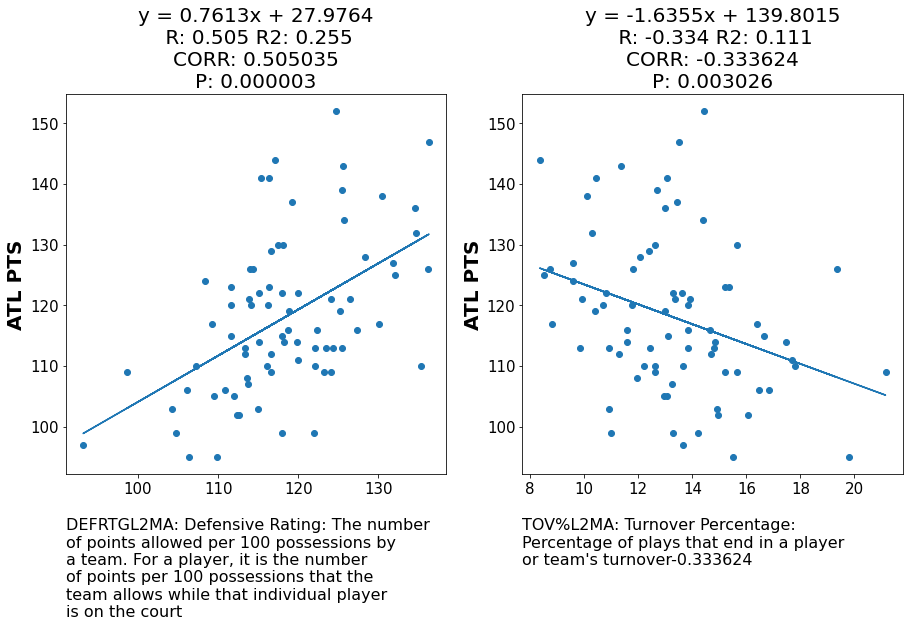

In [798]:
plotTeamMaxMinFeatureToPointsCorrelation('ATL')

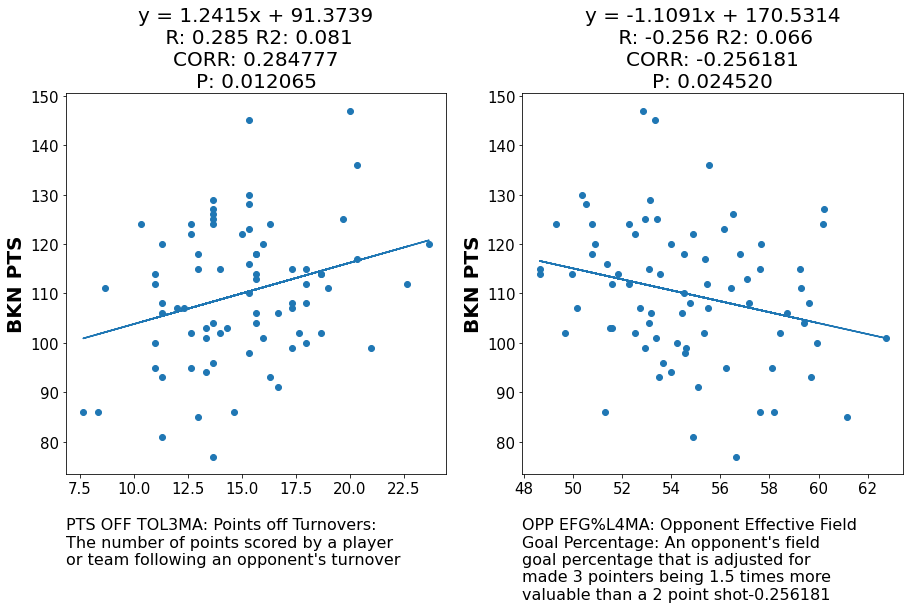

In [799]:
plotTeamMaxMinFeatureToPointsCorrelation('BKN')

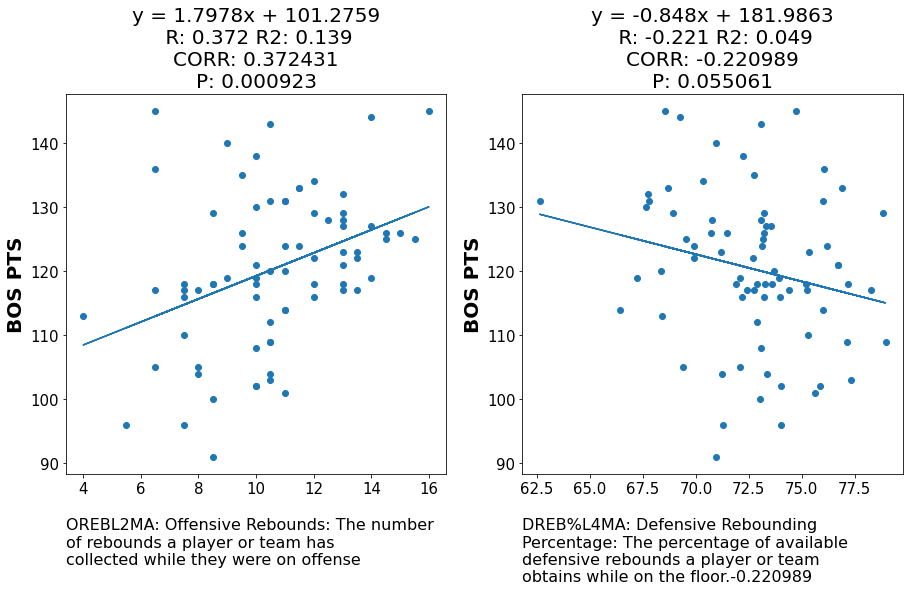

In [800]:
plotTeamMaxMinFeatureToPointsCorrelation('BOS')

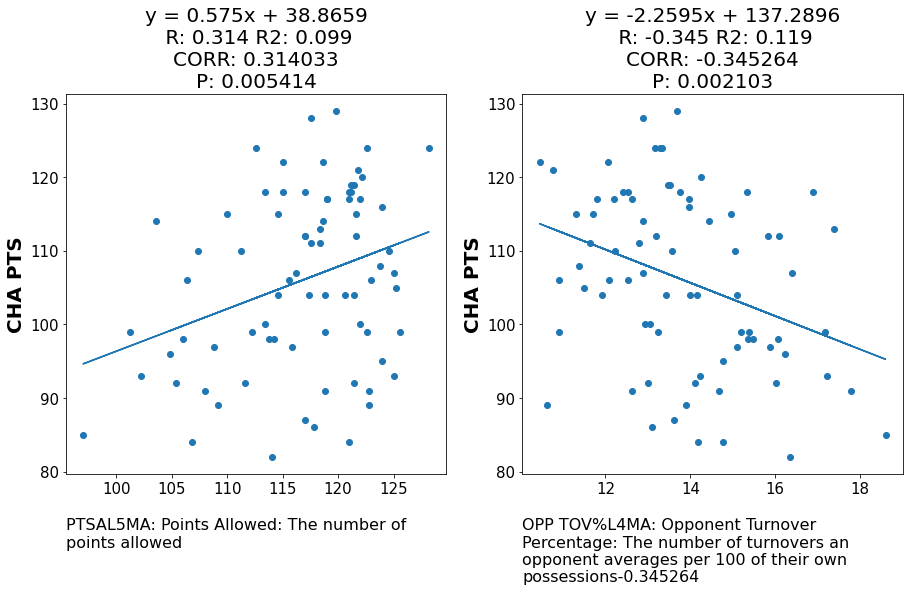

In [801]:
plotTeamMaxMinFeatureToPointsCorrelation('CHA')

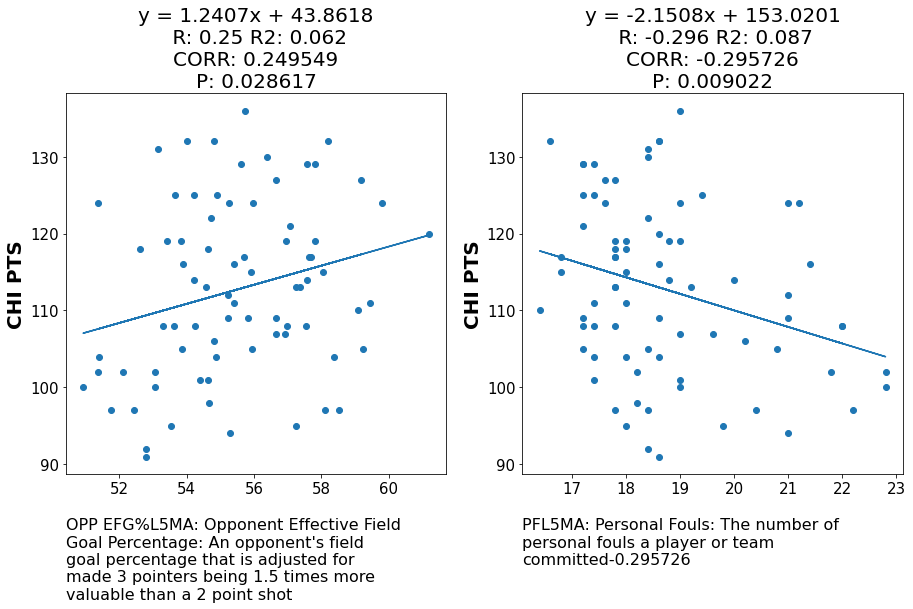

In [802]:
plotTeamMaxMinFeatureToPointsCorrelation('CHI')

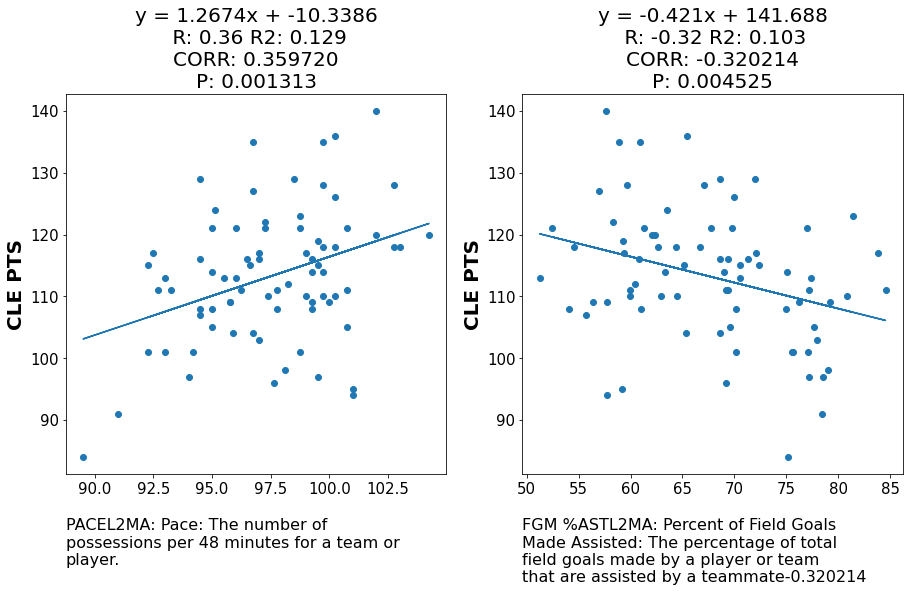

In [803]:
plotTeamMaxMinFeatureToPointsCorrelation('CLE')

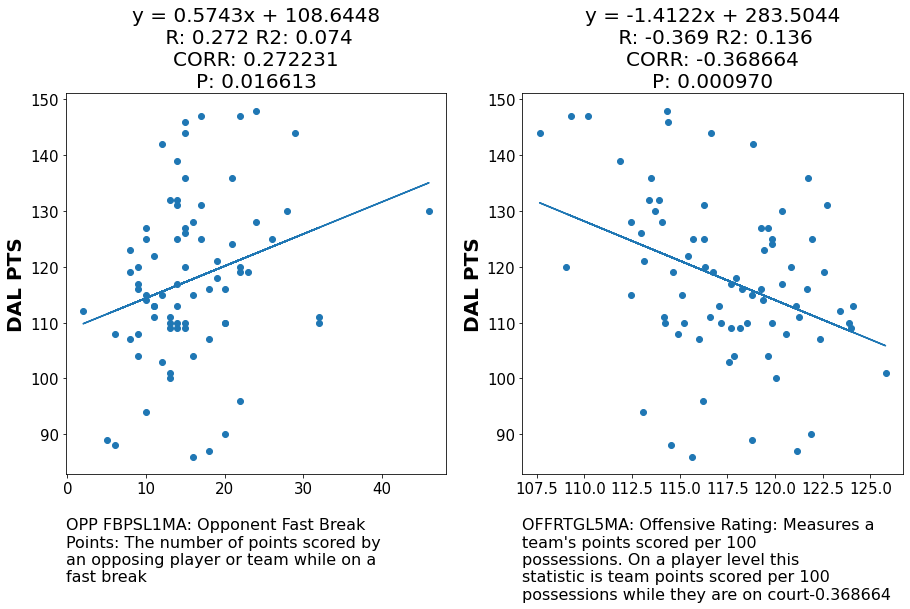

In [804]:
plotTeamMaxMinFeatureToPointsCorrelation('DAL')

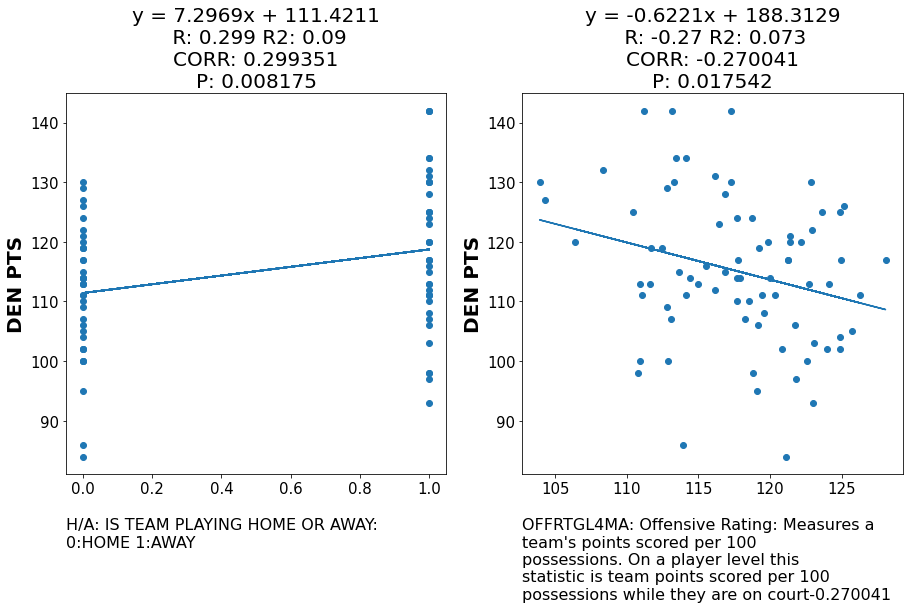

In [805]:
plotTeamMaxMinFeatureToPointsCorrelation('DEN')

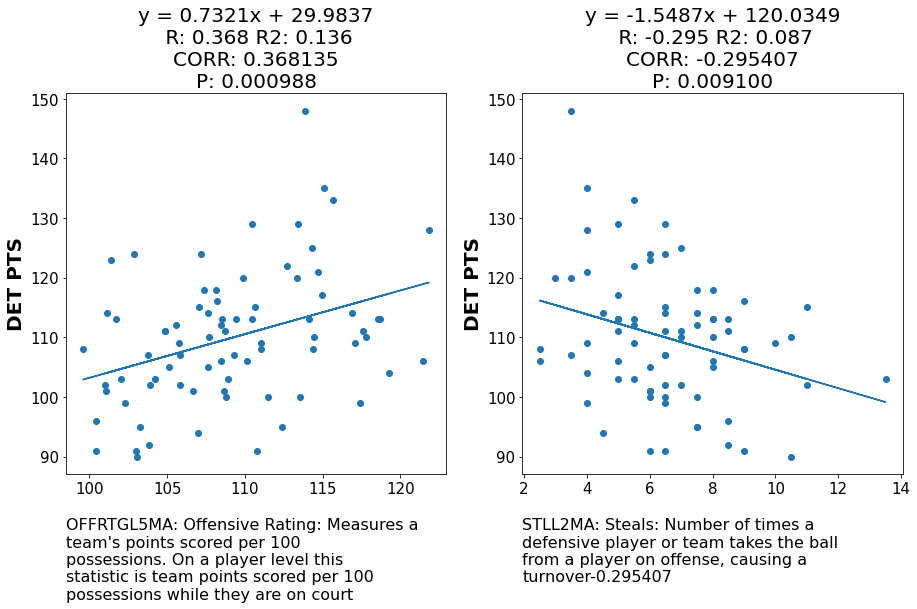

In [806]:
plotTeamMaxMinFeatureToPointsCorrelation('DET')

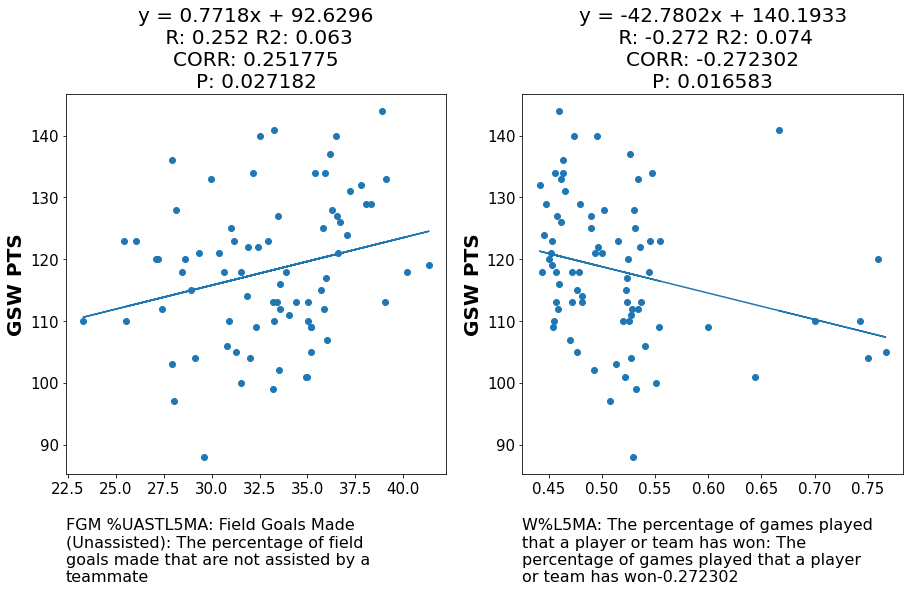

In [807]:
plotTeamMaxMinFeatureToPointsCorrelation('GSW')

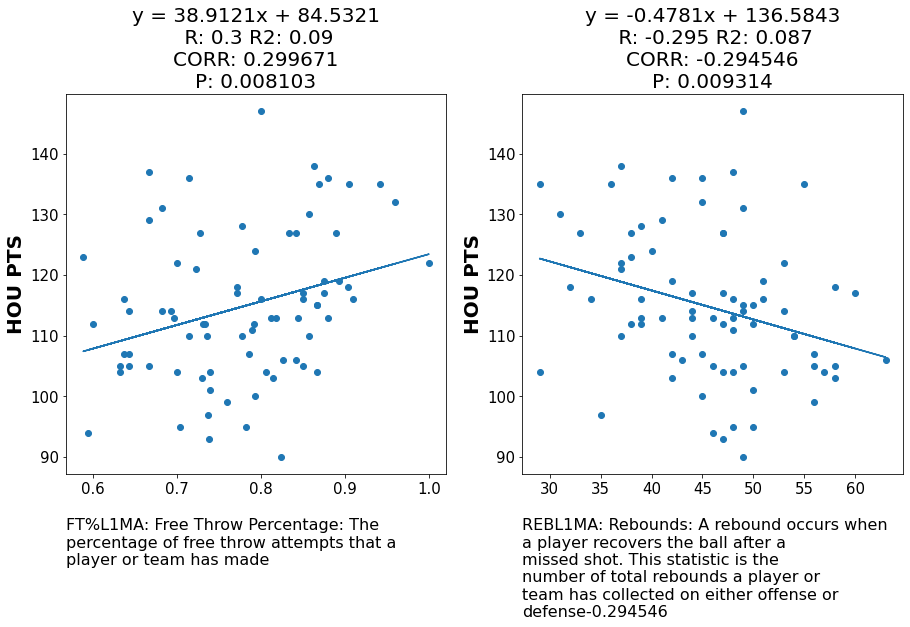

In [808]:
plotTeamMaxMinFeatureToPointsCorrelation('HOU')

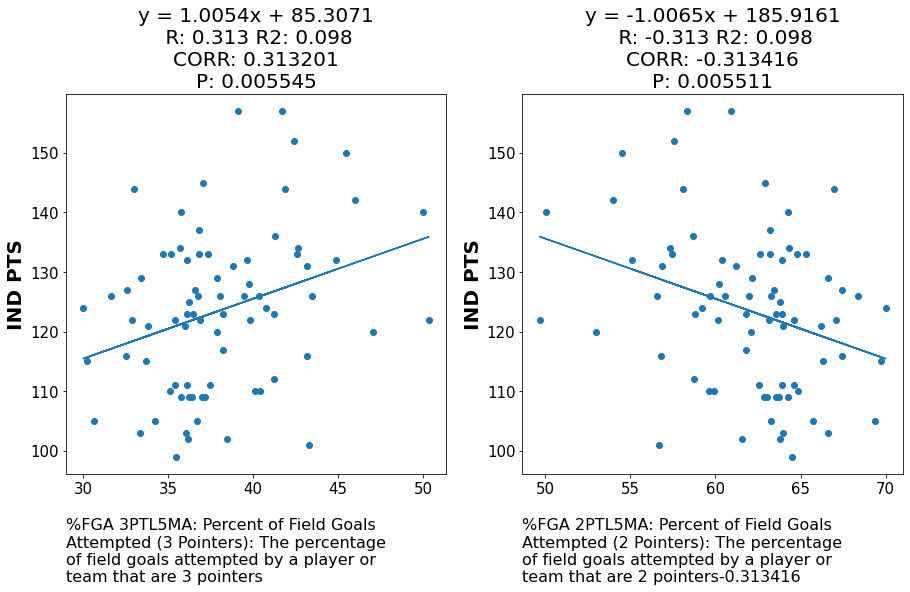

In [809]:
plotTeamMaxMinFeatureToPointsCorrelation('IND')

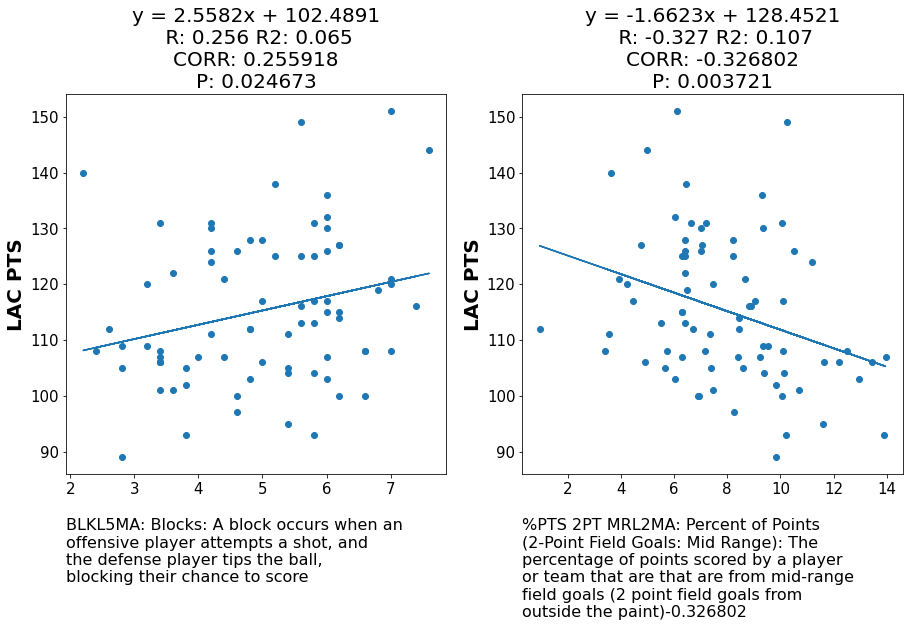

In [810]:
plotTeamMaxMinFeatureToPointsCorrelation('LAC')

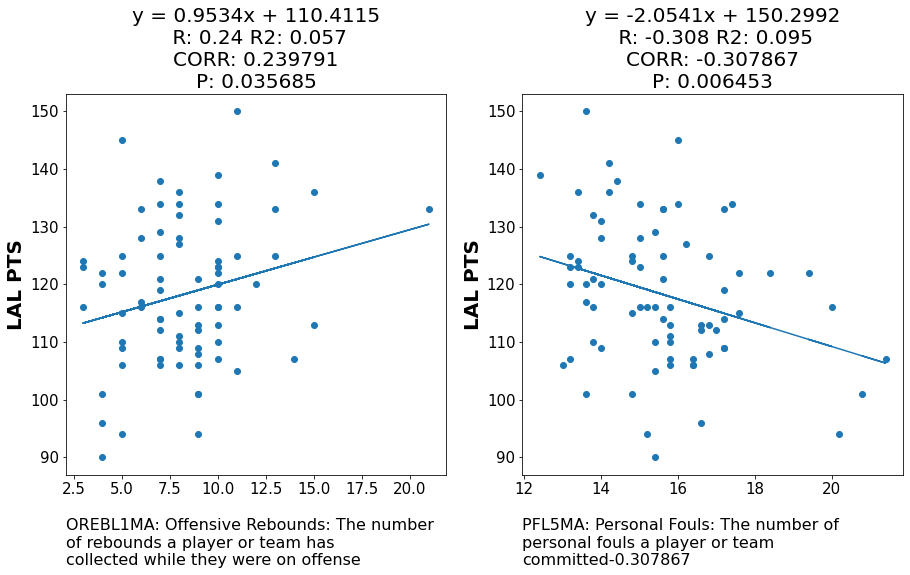

In [811]:
plotTeamMaxMinFeatureToPointsCorrelation('LAL')

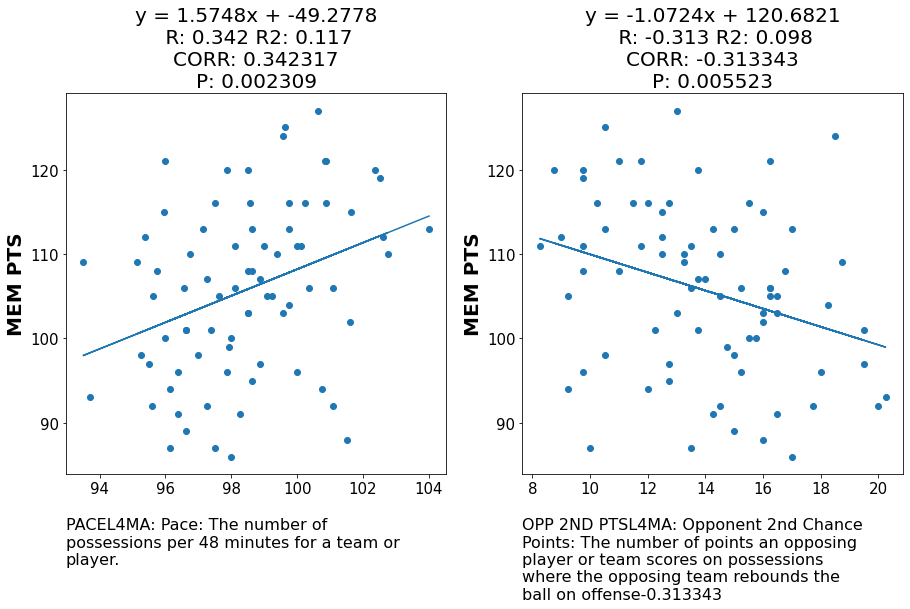

In [812]:
plotTeamMaxMinFeatureToPointsCorrelation('MEM')

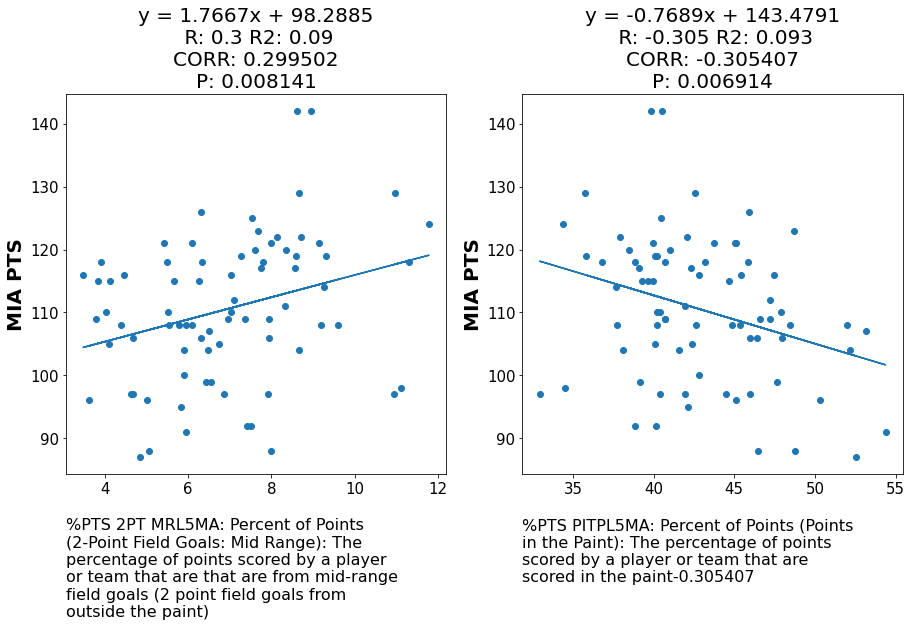

In [813]:
plotTeamMaxMinFeatureToPointsCorrelation('MIA')

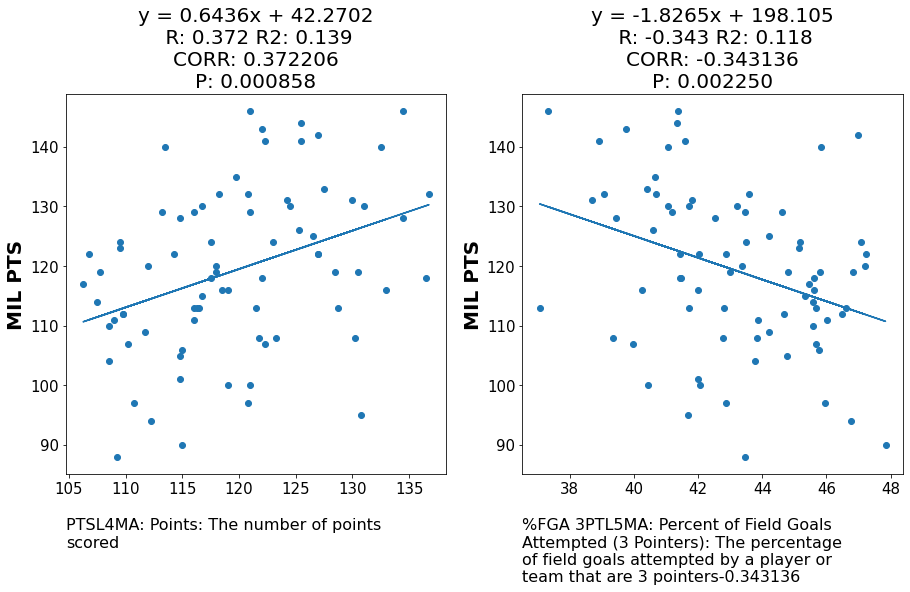

In [829]:
plotTeamMaxMinFeatureToPointsCorrelation('MIL')

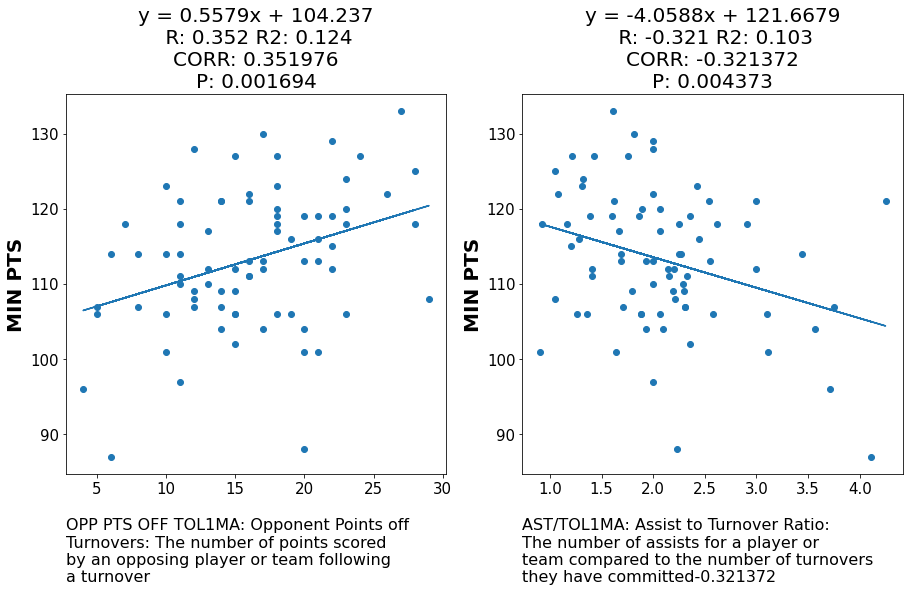

In [816]:
plotTeamMaxMinFeatureToPointsCorrelation('MIN')

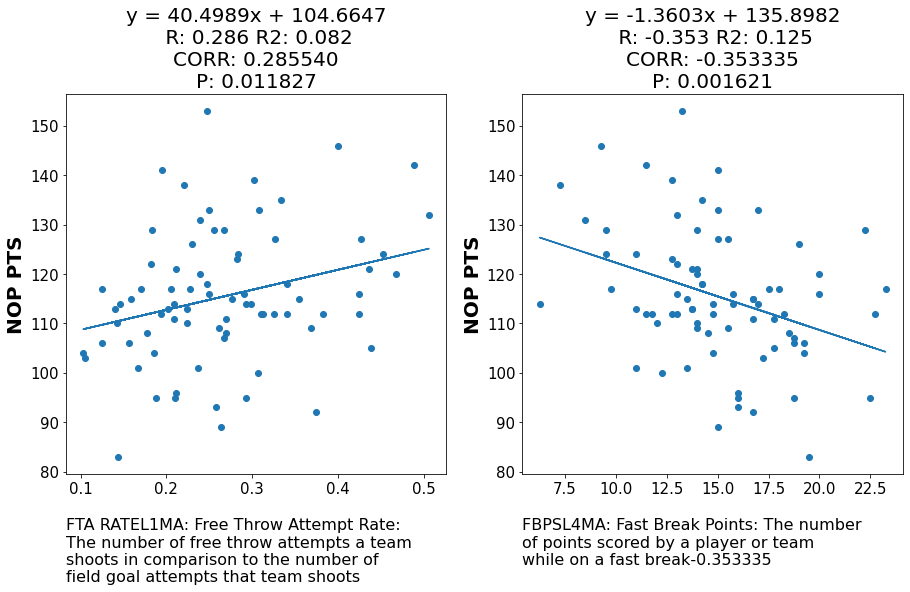

In [817]:
plotTeamMaxMinFeatureToPointsCorrelation('NOP')

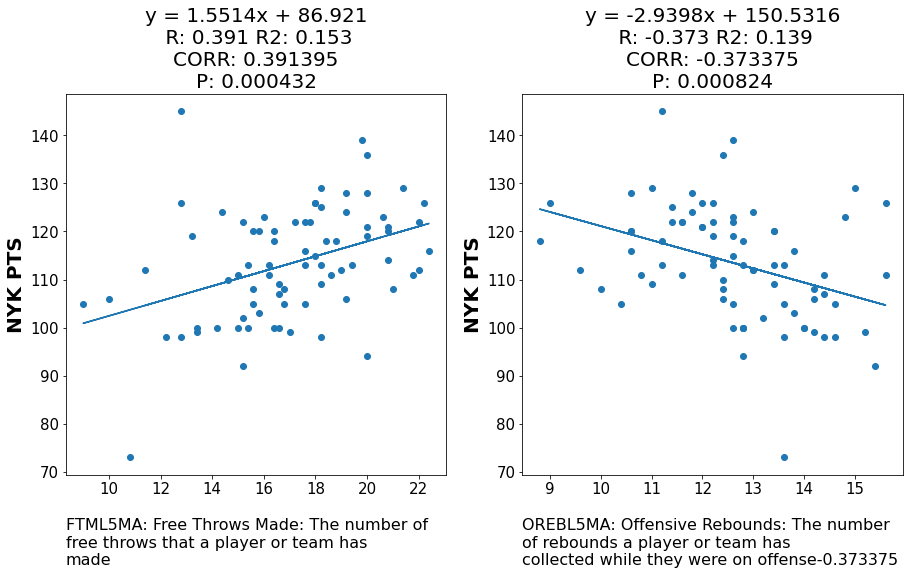

In [818]:
plotTeamMaxMinFeatureToPointsCorrelation('NYK')

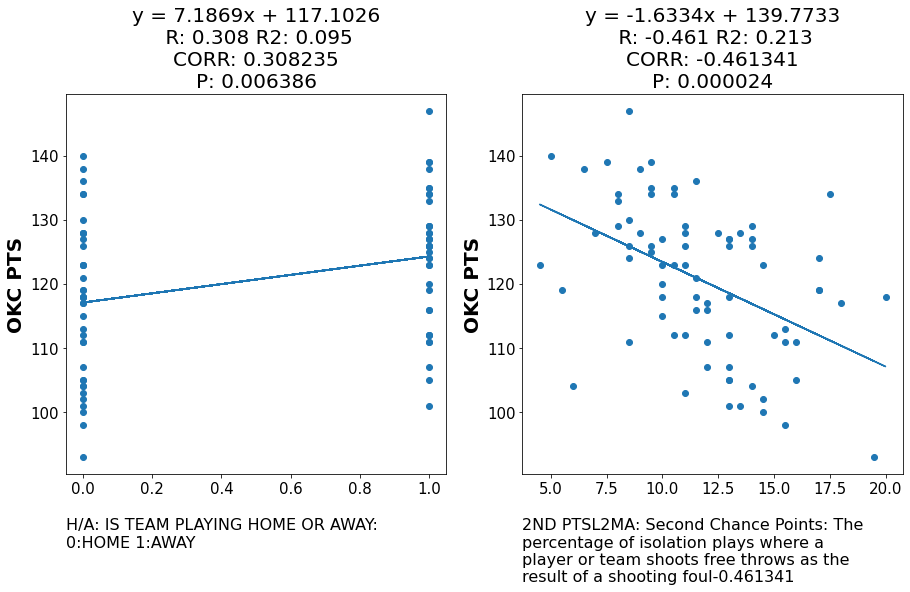

In [819]:
plotTeamMaxMinFeatureToPointsCorrelation('OKC')

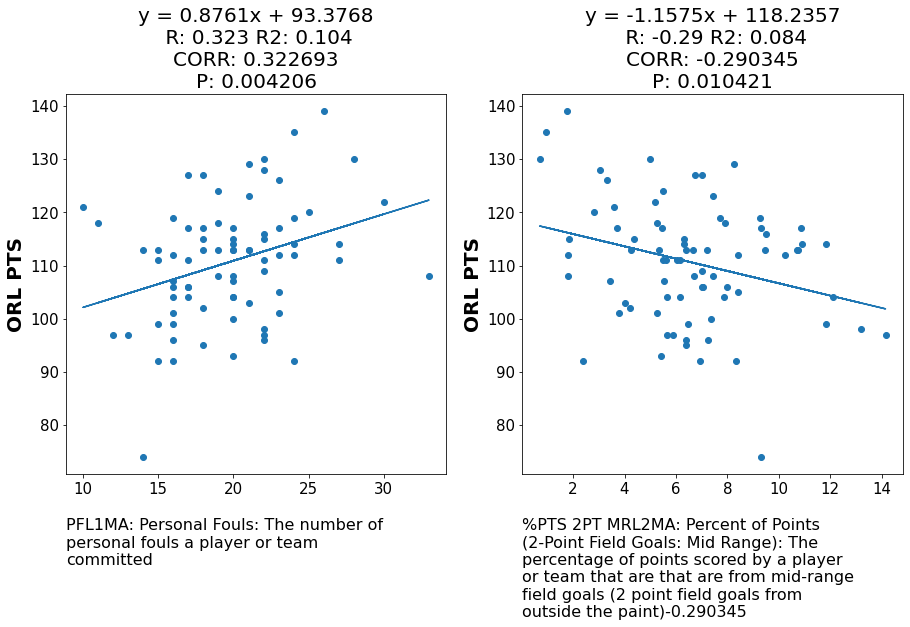

In [820]:
plotTeamMaxMinFeatureToPointsCorrelation('ORL')

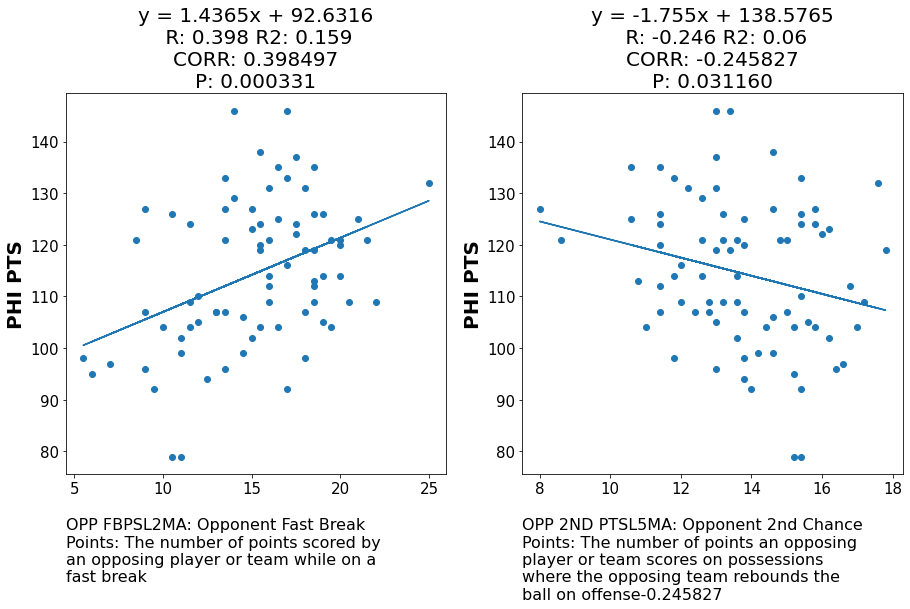

In [821]:
plotTeamMaxMinFeatureToPointsCorrelation('PHI')

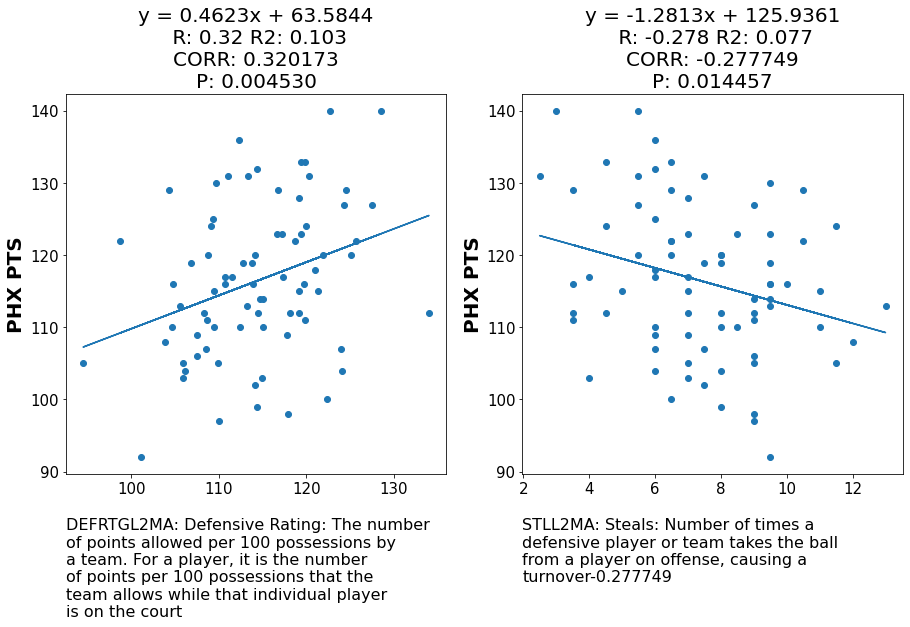

In [822]:
plotTeamMaxMinFeatureToPointsCorrelation('PHX')

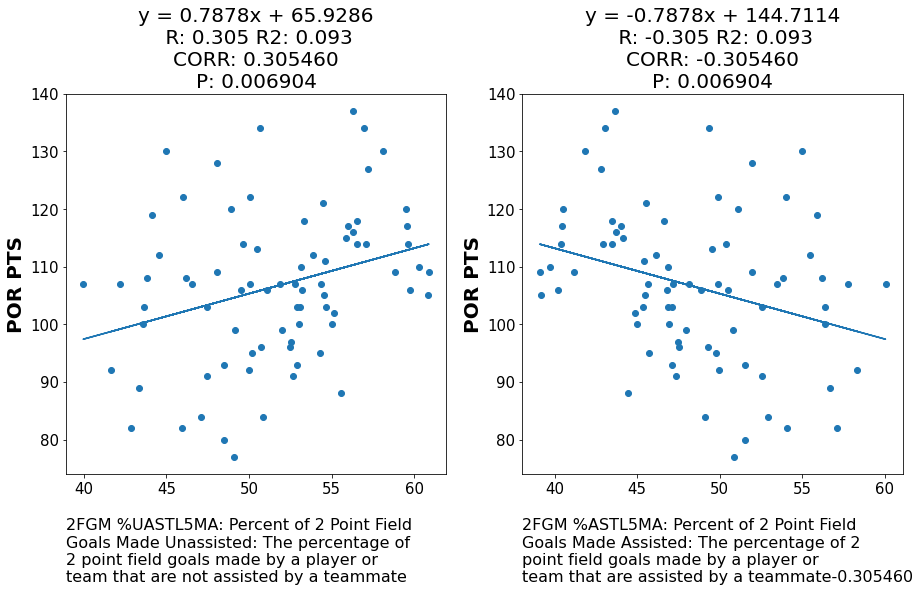

In [823]:
plotTeamMaxMinFeatureToPointsCorrelation('POR')

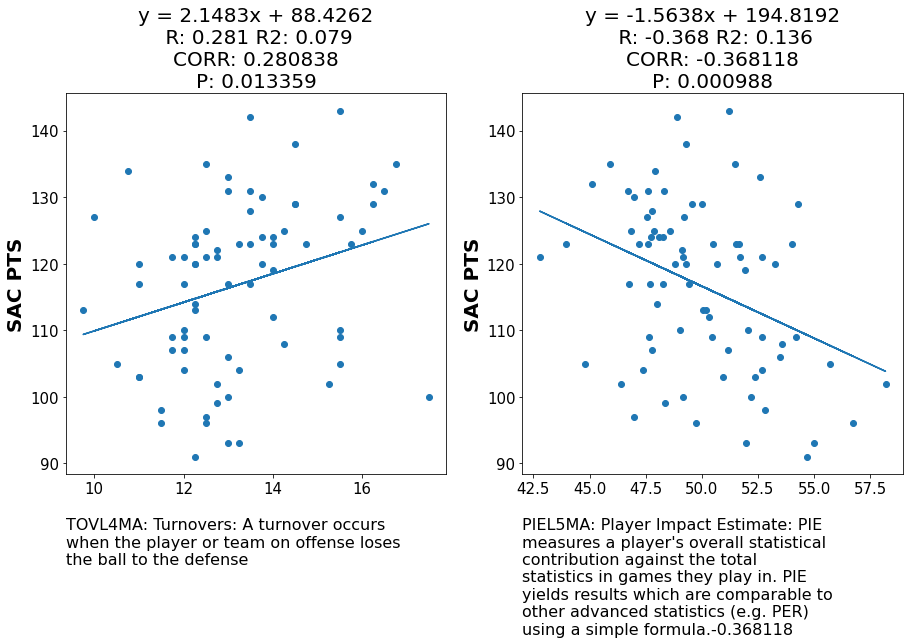

In [824]:
plotTeamMaxMinFeatureToPointsCorrelation('SAC')

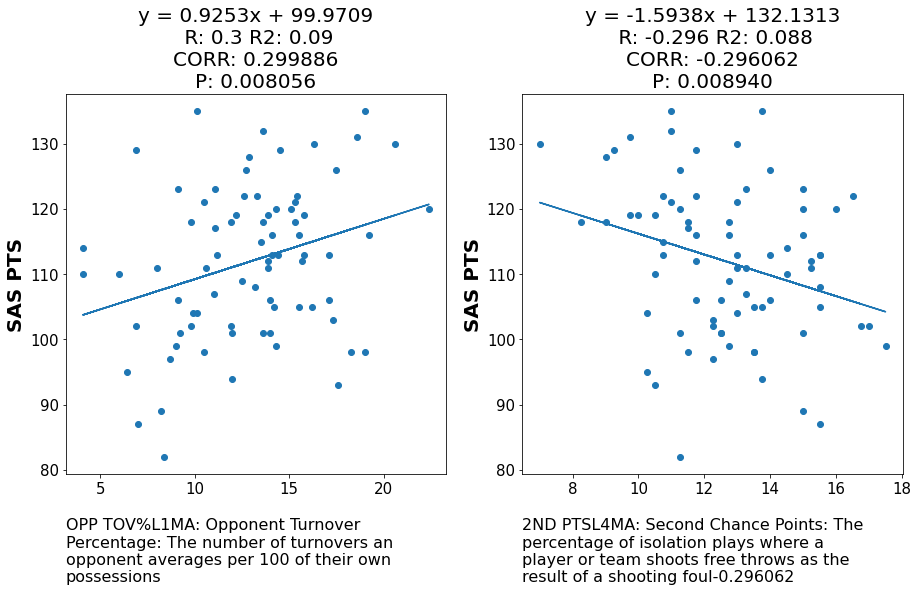

In [825]:
plotTeamMaxMinFeatureToPointsCorrelation('SAS')

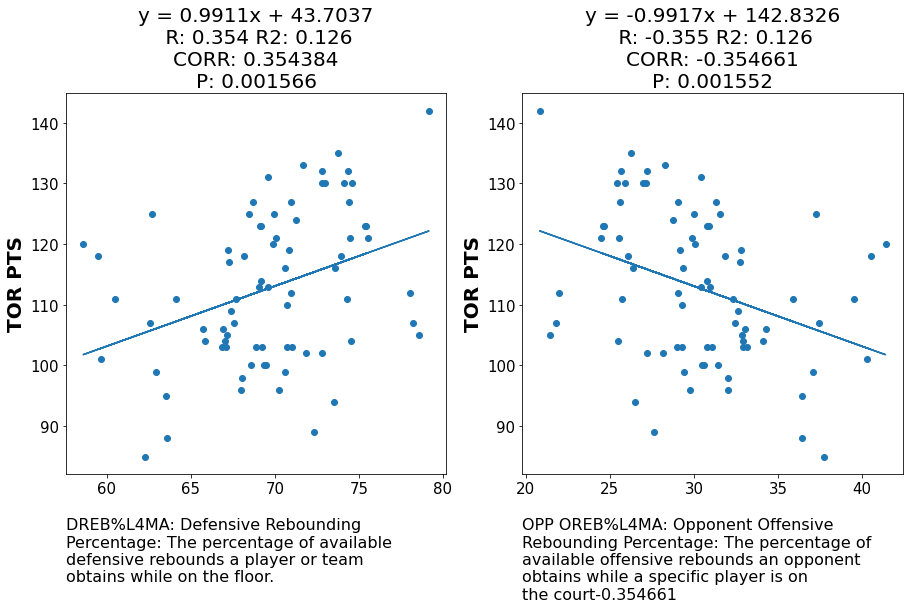

In [826]:
plotTeamMaxMinFeatureToPointsCorrelation('TOR')

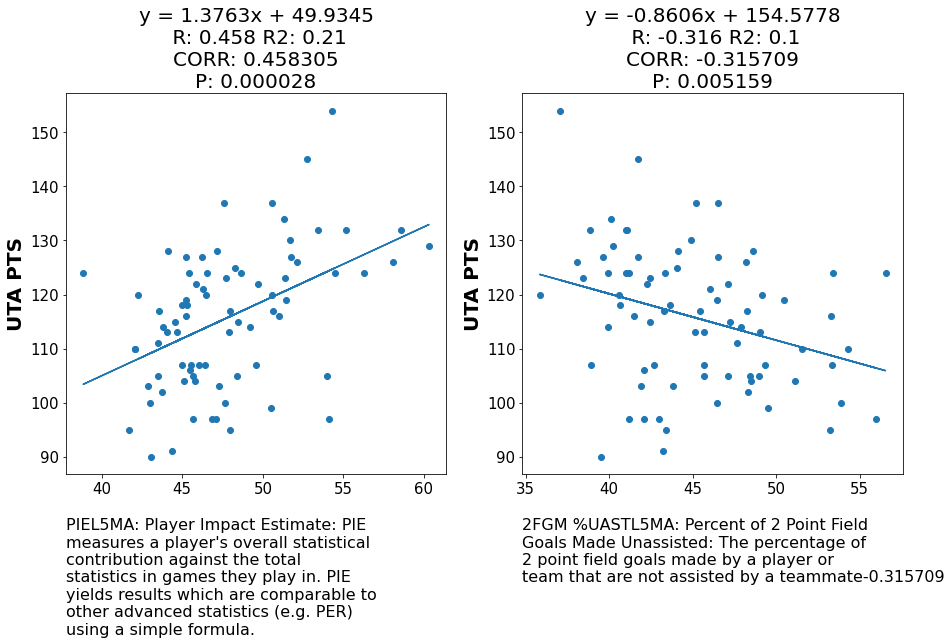

In [827]:
plotTeamMaxMinFeatureToPointsCorrelation('UTA')

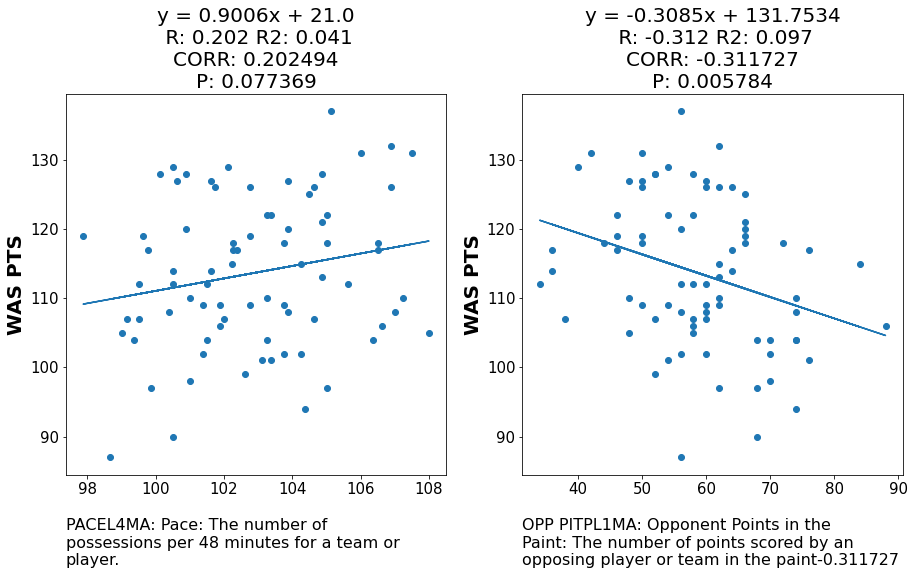

In [828]:
plotTeamMaxMinFeatureToPointsCorrelation('WAS')